# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,537.5635,0.2880,-74.3946
TRXUSDT,79.6748,75.6235,0.0405,-4.0513
JASMYUSDT,453.8661,242.2976,0.1298,-211.5685
SOLUSDT,261.7091,244.0911,0.1308,-17.6180
OMUSDT,535.6761,570.5183,0.3056,34.8422
ETHUSDT,264.2048,162.7809,0.0872,-101.4238
BBUSDT,46.3321,32.9447,0.0176,-13.3874
BNBUSDT,1.1490,0.9272,0.0005,-0.2219
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [10]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [11]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [12]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [13]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [14]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [15]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [16]:
positions

,BBUSDT,BNBUSDT,BTCUSDT,ETHUSDT,JASMYUSDT,OMUSDT,PEPEUSDT,SOLUSDT,TRXUSDT
2024-09-04,34.714117,0.020365,589.726951,169.923286,239.227264,201.446899,0.000002,239.274816,283.720951
2024-09-05,32.793315,0.020156,571.508466,164.244639,230.656020,190.045030,0.000002,231.701242,283.343231
2024-09-06,33.037781,0.019546,548.955041,154.289326,233.598387,186.258277,0.000002,223.894910,279.560844
2024-09-07,34.679193,0.019799,550.968138,157.641739,232.958742,179.621058,0.000002,228.657488,286.559904
2024-09-08,34.900376,0.020184,558.181576,159.286397,235.517322,183.220553,0.000002,233.026169,289.776015
2024-09-09,37.240261,0.020810,580.277428,163.599118,247.670579,201.904638,0.000002,241.853054,300.154099
2024-09-10,36.041216,0.020742,586.319975,165.611259,257.009397,219.007443,0.000002,242.837798,297.241866
2024-09-11,33.596560,0.021268,583.288580,162.285194,255.346320,222.440487,0.000002,237.090475,297.824313
2024-09-12,34.946941,0.021845,591.369046,163.755818,257.137326,241.790376,0.000002,243.589784,295.106229
2024-09-13,38.264689,0.022323,615.434659,169.124532,270.058157,234.487353,0.000002,248.907400,289.281764


In [17]:
positions=positions.sort_index()

In [18]:
positions.index=pd.to_datetime(positions.index)

In [19]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [20]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [21]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [22]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [23]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [24]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [25]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [26]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [27]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

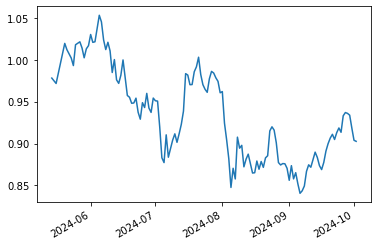

In [28]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [29]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [30]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [31]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XECUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [32]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9370
OMUSDT,0.0233
TRXUSDT,0.0182
BNBUSDT,0.0156
PEPEUSDT,0.0048
JASMYUSDT,0.0008
SUIUSDT,0.0002
CKBUSDT,0.0002
STXUSDT,0.0000
FDUSDUSDT,0.0000


In [34]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.508716
BTCUSDT,0.400000
PEPEUSDT,0.074060
BNBUSDT,0.017224


In [35]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [36]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.758026
OMUSDT,0.241974


## Real Portfolio vs Optimal

In [37]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,570.518347,0.305622,0.241974,0.063648
BTCUSDT,537.563452,0.287968,0.000000,0.000000
SOLUSDT,244.091108,0.130757,0.000000,0.000000
JASMYUSDT,242.297560,0.129797,0.000000,0.000000
ETHUSDT,162.780949,0.087200,0.000000,0.000000
TRXUSDT,75.623505,0.040511,0.758026,-0.717515
BBUSDT,32.944651,0.017648,0.000000,0.000000
BNBUSDT,0.927165,0.000497,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [38]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,570.518347,0.305622,0.508716,-0.203094
BTCUSDT,537.563452,0.287968,0.400000,-0.112032
SOLUSDT,244.091108,0.130757,0.000000,0.000000
JASMYUSDT,242.297560,0.129797,0.000000,0.000000
ETHUSDT,162.780949,0.087200,0.000000,0.000000
TRXUSDT,75.623505,0.040511,0.000000,0.000000
BBUSDT,32.944651,0.017648,0.000000,0.000000
BNBUSDT,0.927165,0.000497,0.017224,-0.016727
PEPEUSDT,0.000002,0.000000,0.074060,-0.074060


# Risk Reward Analysis

In [39]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [40]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

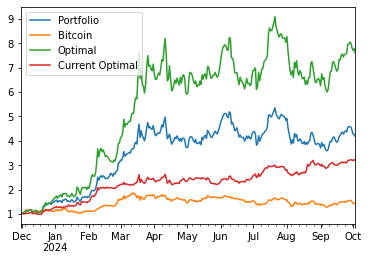

In [41]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [42]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

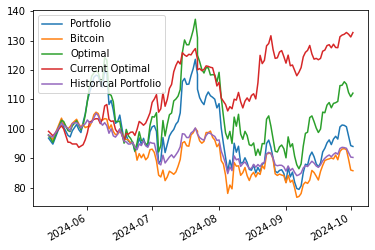

In [43]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [98]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-23,96.508450,89.756842,108.623539,128.747090,91.298984
2024-09-24,97.444738,91.054949,108.869184,127.636340,91.853987
2024-09-25,96.502346,89.467434,109.300182,127.571485,91.339446
2024-09-26,100.635490,92.287070,114.674322,131.279857,93.306318
2024-09-27,101.284431,93.127121,114.813115,131.859644,93.693252
2024-09-28,101.156519,93.251712,115.996915,132.132339,93.595109
2024-09-29,100.682743,92.888537,115.170820,132.733714,93.379558
2024-09-30,97.432107,89.610942,112.310772,132.140637,91.840967
2024-10-01,94.283860,85.969490,110.905504,131.213033,90.386098
2024-10-02,93.992799,85.747939,112.114867,132.708670,90.261509


## Volatilities

In [45]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.754945
dtype: float64

In [46]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.541672
dtype: float64

In [47]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.604558
Bitcoin            0.440822
Optimal            0.756142
Current Optimal    0.404196
dtype: float64

In [48]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2052383740604086

## Risk Contribution

In [49]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.018400,0.017224,0.003093,0.004529,0.000125,0.004404
BTCUSDT,0.172465,0.400000,0.049705,0.143026,0.054380,0.088646
OMUSDT,10.176858,0.508716,0.927780,0.795757,0.705539,0.090218
PEPEUSDT,0.149637,0.074060,0.019423,0.056688,0.015894,0.040794


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.102774,0.241974,0.273376,0.452213,0.389350,0.062864
TRXUSDT,0.158300,0.758026,0.726624,0.547787,0.484923,0.062864


In [51]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.130363,0.306931,0.424921,0.394519,0.228338,0.166182
BTCUSDT,-0.022831,0.287129,0.256820,0.185166,0.047848,0.137318
SOLUSDT,-0.023713,0.128713,0.102029,0.128973,0.025027,0.103947
JASMYUSDT,-0.026524,0.128713,0.099297,0.182094,0.053551,0.128543
ETHUSDT,-0.023830,0.089109,0.063432,0.069552,0.008049,0.061504
TRXUSDT,0.008271,0.039604,0.046520,0.006265,0.000482,0.005783
BBUSDT,-0.012618,0.019802,0.006980,0.033430,0.002679,0.030751


# Value At Risk

## Historical

In [52]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06264092746858616, -0.08854279756260855)

In [53]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05014685502475449, -0.0678837268065235)

In [54]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [55]:
var=historical_var.iloc[row]
var

OMUSDT      -0.008276
BTCUSDT     -0.016065
SOLUSDT     -0.008753
JASMYUSDT   -0.006194
ETHUSDT     -0.007746
TRXUSDT     -0.000917
BBUSDT      -0.002198
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050148
Name: 2024-08-27 00:00:00, dtype: float64

In [56]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.024036
BTCUSDT     -0.013234
SOLUSDT     -0.009971
JASMYUSDT   -0.012551
ETHUSDT     -0.005335
TRXUSDT     -0.000780
BBUSDT      -0.001977
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067884
dtype: float64

## Parametric

In [57]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07834841738367014, -0.10042100894817844)

In [58]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05612586543903319, -0.07193784155048095)

## Multivariate

In [59]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07098031596597995, -0.09065519078162694)

In [60]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05575037970594949, -0.06945489795626245)

In [61]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.020293
BTCUSDT     -0.010586
SOLUSDT     -0.007342
JASMYUSDT   -0.011061
ETHUSDT     -0.003846
TRXUSDT     -0.000281
BBUSDT      -0.001709
Portfolio   -0.055117
dtype: float64

## Copulas

### Gaussian Copula

In [62]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07108843203468668, -0.09117964915308553)

In [63]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05373583020021047, -0.06735970551535558)

In [64]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021231
BTCUSDT     -0.010547
SOLUSDT     -0.007345
JASMYUSDT   -0.009329
ETHUSDT     -0.004233
TRXUSDT     -0.000437
BBUSDT      -0.002065
Portfolio   -0.055188
dtype: float64

### Student Copula

In [65]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06783356931113967, -0.08927364534526343)

In [66]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05498671374118328, -0.0710075818554663)

In [67]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.020599
BTCUSDT     -0.010906
SOLUSDT     -0.007236
JASMYUSDT   -0.010778
ETHUSDT     -0.004308
TRXUSDT     -0.000246
BBUSDT      -0.002121
Portfolio   -0.056194
dtype: float64

### Gumbel Copula

In [68]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.14590819232924684, -0.21133749707969268)

In [69]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06998984753923614, -0.09602311108732875)

In [70]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.046090
BTCUSDT     -0.011153
SOLUSDT     -0.006044
JASMYUSDT   -0.006913
ETHUSDT     -0.001230
TRXUSDT      0.000200
BBUSDT      -0.000344
Portfolio   -0.071574
dtype: float64

### Monte Carlo

In [71]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [72]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0783338204417368, -0.09969337386885786)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05699064631706231, -0.07207496255671125)

In [74]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.023425
BTCUSDT     -0.010705
SOLUSDT     -0.006542
JASMYUSDT   -0.009899
ETHUSDT     -0.004222
TRXUSDT     -0.000375
BBUSDT      -0.001947
Portfolio   -0.057115
dtype: float64

## VaR Violation

In [75]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062608,-0.112718,-0.098086,-0.025041
2024-01-15,-0.062608,-0.112716,-0.095307,0.015585
2024-01-16,-0.062608,-0.113499,-0.094664,0.063847
2024-01-17,-0.062608,-0.115943,-0.097489,-0.036920
2024-01-18,-0.062608,-0.118025,-0.104556,-0.035180
...,...,...,...,...
2024-09-29,-0.042095,-0.073094,-0.065227,-0.007122
2024-09-30,-0.042095,-0.073863,-0.068337,-0.024833
2024-10-01,-0.042095,-0.072271,-0.065458,-0.012512
2024-10-02,-0.042095,-0.065106,-0.059443,0.010904


In [76]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031396,-0.084584,-0.078453,-0.017240
2024-05-29,-0.028946,-0.081756,-0.071726,-0.010048
2024-05-30,-0.028946,-0.070775,-0.066877,0.035047
2024-05-31,-0.028946,-0.069951,-0.061873,0.028069
2024-06-01,-0.028946,-0.071447,-0.061613,0.042567
...,...,...,...,...
2024-09-29,-0.024957,-0.046230,-0.038272,-0.004684
2024-09-30,-0.030102,-0.048016,-0.039492,-0.032286
2024-10-01,-0.032309,-0.052430,-0.046086,-0.032312
2024-10-02,-0.032309,-0.052303,-0.047105,-0.003087


<AxesSubplot:>

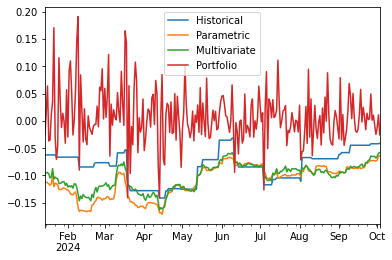

In [77]:
var_data.plot()

<AxesSubplot:>

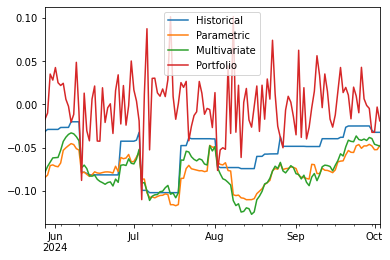

In [78]:
current_var_data.plot()

In [79]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022727,0.011364,0.011364
Kupiec Stat,5.14326,11.919693,11.919693
P-value,0.023337,0.000555,0.000555


In [80]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069767,0.023256,0.023256
Kupiec Stat,0.950032,2.403418,2.403418
P-value,0.329711,0.12107,0.12107


## Principal Component Analysis

### Historical PCA

In [81]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78848044, 0.0675344 , 0.05408945, 0.04597902, 0.04391669])

In [82]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014362
ADAUSDT     0.014711
ALGOUSDT    0.016192
APTUSDT     0.015381
ARBUSDT     0.015917
              ...   
WBTCUSDT    0.010219
WLDUSDT     0.022027
XECUSDT     0.015701
XLMUSDT     0.009815
XRPUSDT     0.009417
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

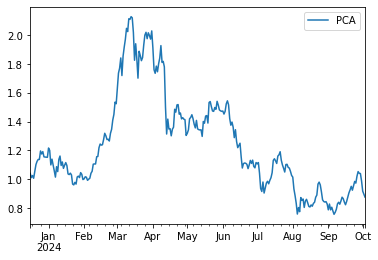

In [83]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

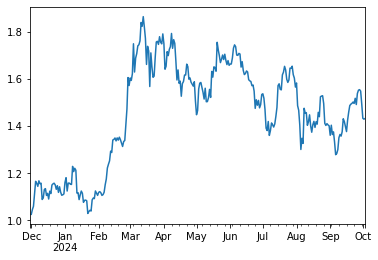

In [84]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [85]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.341685
ALGOUSDT     0.351145
WBETHUSDT    0.355988
ETHUSDT      0.356135
               ...   
PEPEUSDT     1.000887
FLOKIUSDT    1.009268
WLDUSDT      1.047439
CKBUSDT      1.151760
OMUSDT       1.319940
Length: 64, dtype: float64

<AxesSubplot:>

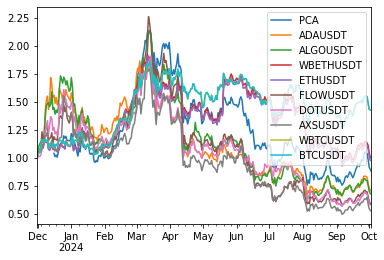

In [86]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

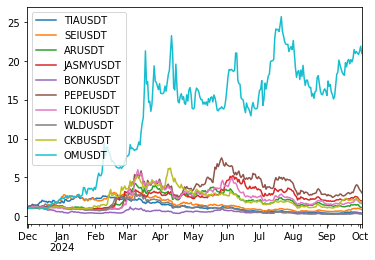

In [87]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [88]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67151742, 0.1380552 , 0.0882883 , 0.07029733, 0.03184176])

In [89]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.096272
BTCUSDT      0.064336
SOLUSDT      0.104079
JASMYUSDT    0.155478
ETHUSDT      0.086639
TRXUSDT      0.015353
BBUSDT       0.244052
BNBUSDT      0.068433
PEPEUSDT     0.165359
Name: PC1, dtype: float64

<AxesSubplot:>

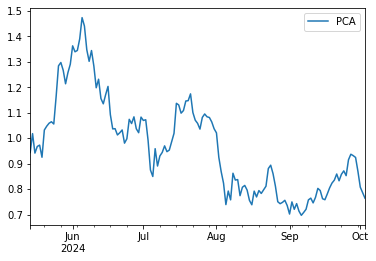

In [90]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

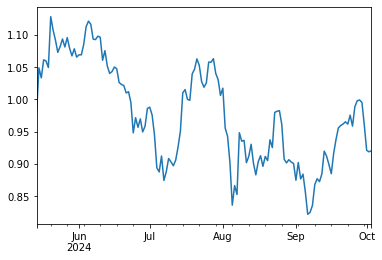

In [91]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [92]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.335610
SOLUSDT      0.345689
BTCUSDT      0.370290
BNBUSDT      0.370343
JASMYUSDT    0.427387
PEPEUSDT     0.474343
TRXUSDT      0.551313
OMUSDT       0.554295
BBUSDT       0.629596
dtype: float64

<AxesSubplot:>

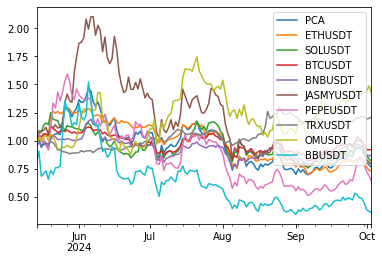

In [93]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [94]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.947261
BBUSDT       1.691209
JASMYUSDT    1.298067
SOLUSDT      1.167311
BTCUSDT      1.000000
OMUSDT       0.975317
ETHUSDT      0.956994
BNBUSDT      0.677898
TRXUSDT      0.280380
Name: BTCUSDT, dtype: float64

In [95]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.622259
BBUSDT       2.403907
JASMYUSDT    2.030794
SOLUSDT      1.546769
ETHUSDT      1.111130
BTCUSDT      1.000000
BNBUSDT      0.948836
TRXUSDT      0.371443
OMUSDT      -0.044214
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [96]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
